 # Importing Libraries and Testing and Loading the Dataset

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

from sklearn.model_selection import train_test_split


import tensorflow as tf
from tqdm import tqdm

import numpy as np #
import pandas as pd 

from keras import Sequential
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from keras.utils import to_categorical
# from keras import regularizers
from tensorflow.keras.models import Model


from keras.preprocessing.image import load_img


In [ ]:
#reading labels csv file

labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.head()

In [ ]:
# Describing the labels 
labels.describe()

In [ ]:
# Showing the CSV as a bar graph
def barg(ax):
    for p in ax.patches:
        val = p.get_width()  # Height of the Bar
        x = p.get_x() + p.get_width() # x position
        y = p.get_y() + p.get_height() / 2 # y postion
        ax.annotate(round(val,2),(x,y))
        
plt.figure(figsize = (15,30))
ax0 =sns.countplot(y=labels['breed'],order=labels['breed'].value_counts().index)
barg(ax0)
plt.show()

In [ ]:
# no of unique breeds 
labels['breed'].nunique()

In [ ]:
# testing one picture 
from IPython.display import display, Image 
Image('../input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

In [ ]:
# Alphabetically sorting labels and putting it into a list 
classes = sorted(list(set(labels['breed'])))
n_classes = len(classes)  # no of unique breeds
print("Total unique breed: {}".format(n_classes))

# Now to map each label string to an integer label for easy use 
# To do this we create a dict
class_to_num = dict(zip(classes, range(n_classes)))

# testing the dict
class_to_num

In [ ]:
# Since the output of our predictor for each input is a vector of probabilities for each class we must, 
# convert out label dataset to be the same format, 
# for this we will use one hot encoding.

input_shape = (331,331,3)  # numbers are specific to each keras model

# maps each image and breed of the image to a numpy array
def images_to_array(directory, label_dataframe, target_size = input_shape):
    
    image_labels = label_dataframe['breed']
    # passes the input shape and all 10222 images from the dataset from the label.csv file
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8) 
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    # as we have huge data and limited ram memory. uint8 takes less memory
    
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')  # creates directory of each image
        img = load_img(img_dir, target_size = target_size)  # reading the image

        images[ix]=img  # saving the image with respect to its id
        del img  # frees memory
        
        dog_breed = image_labels[ix]   # getting breed info for the img
        y[ix] = class_to_num[dog_breed]  # converting breed info to a numerical value 
    
    y = to_categorical(y)  # converting target variable to a one hot encoded matrix     
    
    return images,y

In [ ]:
# Calling the previous cell
import time 
t = time.time()

X,y = images_to_array('/kaggle/input/dog-breed-identification/train', labels[:])

print('runtime in seconds: {}'.format(time.time() - t))

In [ ]:
# To test the previous function, I will now print some images with their breed info from the train folder

n = 25

plt.figure(figsize=(20,20))

for i in range(n):
    x = plt.subplot(5, 5, i+1)
    plt.title(classes[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32')) # converting to int as imshow() needs integer data to read the image

# Creating Callbacks

In [ ]:
# Learning Rate Annealer automatically reduces learning rate when a metric has stopped improving. 
# by monitoring the validation accuracy
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5,verbose = 1) 

# Prepare call backs
# Monitors validation loss and stops the training if nothing significant is happening 
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Creating hyperparameters
batch_size = 128
epochs = 50
learn_rate = .001
# creating optimizers 
sgd = SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

# Model Building 
### * The basic idea here is to extract features from the data set from pretrained models and create a simple deep net by using all those features combined.
### * So we will use **GlobalAveragePooling2D** to extract a pooled output from our selected models
### * Models I will use:
###   1. **Inception**
###   2. **Xception**
###   3. **NASNETLarge**
###   4. **InceptionResnetV2**
### * Using these models I will extract features and combine them to create a combines feature map
### * I will then feed this feature map to a neural net with an inputlayer and a softmax layer
### * As a softmax layer is used, the loss function generated will be Categorical Cross Entropy
### * This will lead to an output

In [ ]:
# Function to extract features from the dataset by a given pretrained model
img_size = (331,331,3)

# the name of each model is passed along with its preprocessor unit and an input size and some data
def get_features(model_name, model_preprocessor, input_size, data):
    
    # The data enters the input layer with the dimention of input size 
    input_layer = Input(input_size)
    # On the input layer I apply the preprocessor to create the required preprocessed input 
    preprocessor = Lambda(model_preprocessor)(input_layer)
    # The model now extracts features from the preprocessed input 
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    # I apply globalaveragepooling to the output to average all values
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    
    # Extract feature.
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

### InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

### Xception

In [ ]:
from keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
xception_features = get_features(Xception,
                                 xception_preprocessor,
                                 img_size, X)

### InceptionResNetV2

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
inc_resnet_features = get_features(InceptionResNetV2,
                                   inc_resnet_preprocessor,
                                   img_size, X)

### NASNetLarge

In [ ]:
from keras.applications.nasnet import NASNetLarge, preprocess_input
nasnet_preprocessor = preprocess_input
nasnet_features = get_features(NASNetLarge,
                               nasnet_preprocessor,
                               img_size, X)

In [ ]:
del X  # To free up some ram as its not needed seeing as the feature map has been made 
gc.collect()

## Combining all the feature maps

In [ ]:
final_features = np.concatenate([inception_features,
                                 xception_features,
                                 nasnet_features,
                                 inc_resnet_features,], axis=-1)  # axis=-1 to concatinate horizontally

print('Final feature maps shape', final_features.shape)

# Creating the Neural net

### As we are useing a Softmax layer, the loss function used is **Categorical Cross Entropy**. Below is the formala
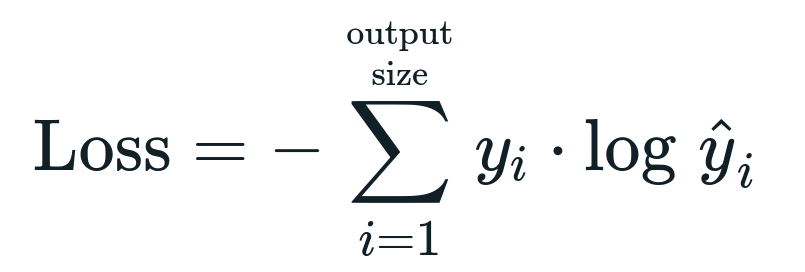

### where, $ y_{i} $ is the observed data and, $\hat{y}_{i}$ is the predicted value 

In [ ]:
# Prepare Deep net
model = Sequential()
model.add(Dropout(0.7,input_shape=(final_features.shape[1],)))
model.add(Dense(n_classes,activation= 'softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model. 
history = model.fit(final_features, y,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=[lrr,EarlyStop])

In [ ]:
# Deleting to free up ram memory

del inception_features
del xception_features
del nasnet_features
del inc_resnet_features
del final_features
gc.collect()

In [ ]:
# Function to read images from test directory
# This is the same as the previous images_to_array function but now applied to test data

def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]

    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    
    for ix,img_dir in enumerate(tqdm(test_filenames)):
        img = load_img(img_dir, target_size = img_size)
        images[ix]=img
        del img
    print('Ouptut Data Size: ', images.shape)
    return images

test_data = images_to_array_test('/kaggle/input/dog-breed-identification/test/', img_size)

In [ ]:
# Extract test data features.
def extact_features(data):
    # Getting Inception features
    inception_features = get_features(InceptionV3, inception_preprocessor, img_size, data)
    # Getting Xception features
    xception_features = get_features(Xception, xception_preprocessor, img_size, data)
    # Getting NASNetLarge features
    nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, img_size, data)
    # Getting InceptionResNet features
    inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, img_size, data)

    # Concatenating all features
    final_features = np.concatenate([inception_features,
                                     xception_features,
                                     nasnet_features,
                                     inc_resnet_features],axis=-1)
    
    print('Final feature maps shape', final_features.shape)
    
    #deleting to free up ram memory
    del inception_features
    del xception_features
    del nasnet_features
    del inc_resnet_features
    gc.collect()
    
    
    return final_features

test_features = extact_features(test_data)

In [ ]:
#Free up some space.
del test_data
gc.collect()

In [ ]:
#Predict test labels given test data features.
pred = model.predict(test_features)

In [ ]:
# First prediction
print(pred[0])
# The max probability value predicted by the model
print(f"Max value (probability of prediction): {np.max(pred[0])}") 

# Because we used softmax activation in our model, this will be close to 1
print(f"Sum: {np.sum(pred[0])}") 

# The index of where the max value in predictions[0] occurs
print(f"Max index: {np.argmax(pred[0])}") 
print(f"Predicted label: {classes[np.argmax(pred[0])]}")

# Creating a file for all the predictions

In [ ]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(classes))
preds_df.head()

In [ ]:
# Append test image ID's to predictions DataFrame
test_path = "/kaggle/input/dog-breed-identification/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
preds_df.loc[:,list(classes)]= pred

preds_df.to_csv('result.csv',index=None)
preds_df.head()